In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0'

In [3]:
import xarray as xr
import os

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Temperature data 

In [4]:
!ls /srv/scratch/z3289452/OceanDataScience/Mooring/PH100/ 

broken
IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc


In [5]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [6]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [7]:
bins = [0,11,19,20,28,106,114,116]
labs = [5.5,15,19.5,24,(106-28)/2,110,115]

In [8]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [9]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs, include_lowest=True)

In [10]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1D').mean().drop(columns=['PRES']).dropna()

In [11]:
temp_df.groupby('PRES_BIN').count()

,TEMP
PRES_BIN,
5.5,284
15.0,1722
19.5,115
24.0,358
39.0,16
110.0,2802
115.0,105


Based on the binning above, three models will be trained: 15 dbar, 24 dbar and 110 dbar.

### 15 dbar

In [12]:
temp_df_15 = temp_df.xs(15)

In [13]:
temp_df_15

,TEMP
TIME,
2011-03-30,23.995378
2011-03-31,23.710236
2011-04-01,23.333200
2011-04-02,22.781210
2011-04-03,22.811733
...,...
2017-08-23,17.224247
2017-08-24,17.473562
2017-08-25,17.870966


In [115]:
temp_df_15_wgaps = temp_df_15.asfreq(freq='1D')

In [116]:
temp_df_15_wgaps

,TEMP
TIME,
2011-03-30,23.995378
2011-03-31,23.710236
2011-04-01,23.333200
2011-04-02,22.781210
2011-04-03,22.811733
...,...
2017-08-23,17.224247
2017-08-24,17.473562
2017-08-25,17.870966


Text(0.5, 0, 'Time (years)')

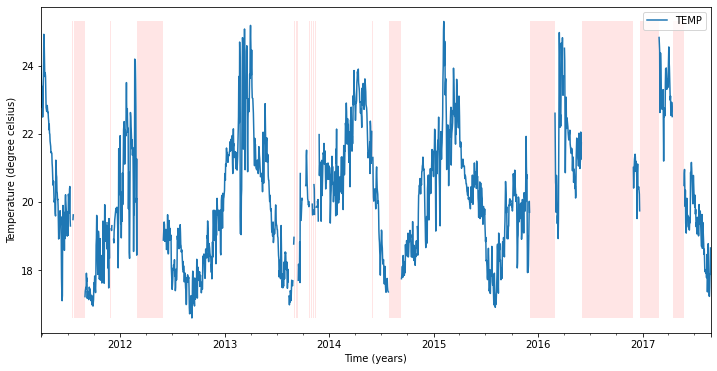

In [16]:
fig, ax = plt.subplots()
import matplotlib.transforms as mtransforms
temp_df_15_wgaps.plot(ax = ax, figsize=(12,6))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(temp_df_15_wgaps.index, temp_df_15_wgaps.TEMP.min(), temp_df_15_wgaps.TEMP.max(), where=np.isnan(temp_df_15_wgaps.TEMP),
                facecolor='red', alpha=0.1)
plt.ylabel("Temperature (degree celsius)")
plt.xlabel("Time (years)")

In [17]:
# !!Important!! Run this code
Time_diff = temp_df_15.index.to_series().diff()

#### Model

In [19]:
class descaled_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
    def __init__(self, mu, sd, reduction=keras.losses.Reduction.AUTO, name='descaled_mape'):
        super().__init__(reduction=reduction, name=name)
        self.mu=mu
        self.sd=sd
    
    def call(self, y_true, y_pred):
        y_true = y_true * self.sd + self.mu
        y_pred = y_pred * self.sd + self.mu
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))

#### Bidirectional tri-layer LSTM model with 10 target time-steps

In [20]:
hist_len = 30
targ_len = 10

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15))
window_len = hist_len + targ_len

In [21]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i:i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [22]:
data.shape, labels.shape

((1044, 30, 1), (1044, 10, 1))

In [23]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))

In [24]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [25]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

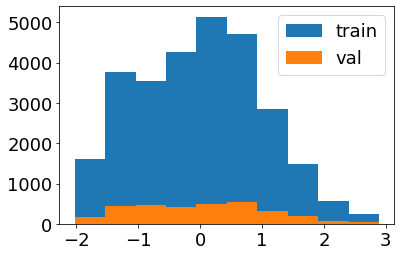

In [26]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

In [32]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [27]:
bidirectional_lstm_targ10_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(10)
])

bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [119]:
# check output shape of model
bidirectional_lstm_targ10_model.predict(val_univariate.take(1)).shape

(8, 10)

In [120]:
checkpoint_path = "../data/bidirectional_lstm_daily_hist30_targ10_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [121]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 200

history = bidirectional_lstm_targ10_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0571, val_loss:  0.0387
..........loss:  0.0317, val_loss:  0.0322
..........loss:  0.0306, val_loss:  0.0309
..........loss:  0.0263, val_loss:  0.0277
..........loss:  0.0239, val_loss:  0.0259
..........loss:  0.0236, val_loss:  0.0244
..........loss:  0.0198, val_loss:  0.0213
..........loss:  0.0174, val_loss:  0.0188
..........loss:  0.0166, val_loss:  0.0188
..........loss:  0.0161, val_loss:  0.0178
..........loss:  0.0149, val_loss:  0.0174
..........loss:  0.0145, val_loss:  0.0170
..........loss:  0.0144, val_loss:  0.0171
..........loss:  0.0133, val_loss:  0.0171
..........loss:  0.0129, val_loss:  0.0158
..........loss:  0.0124, val_loss:  0.0158
..........loss:  0.0122, val_loss:  0.0155
..........loss:  0.0116, val_loss:  0.0157
..........loss:  0.0120, val_loss:  0.0148
..........loss:  0.0116, val_loss:  0.0141
..........

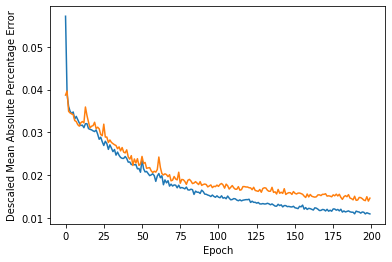

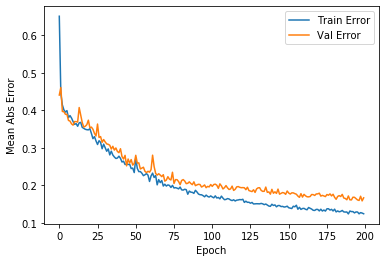

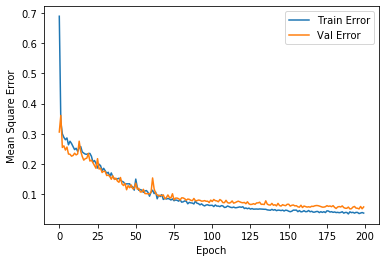

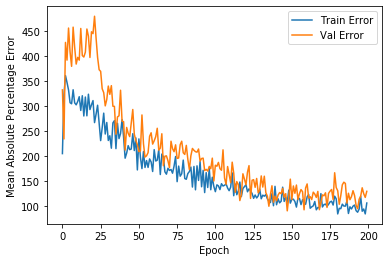

In [122]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [124]:
## Save model
bidirectional_lstm_targ10_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5')

In [27]:
#load model if already trained
bidirectional_lstm_targ10_model = keras.models.load_model('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist30_targ10_loss-descaledmape.h5', compile=False)
bidirectional_lstm_targ10_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])

In [28]:
bidirectional_lstm_targ10_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection multiple                  33792     
_________________________________________________________________
bidirectional_5 (Bidirection multiple                  41216     
_________________________________________________________________
bidirectional_6 (Bidirection multiple                  4672      
_________________________________________________________________
dense_2 (Dense)              multiple                  170       
Total params: 79,850
Trainable params: 79,850
Non-trainable params: 0
_________________________________________________________________


In [29]:
def create_time_steps(length):
  return list(range(-length, 0))

In [30]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

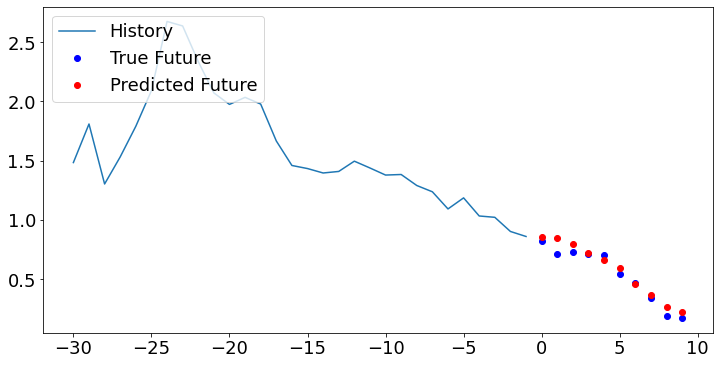

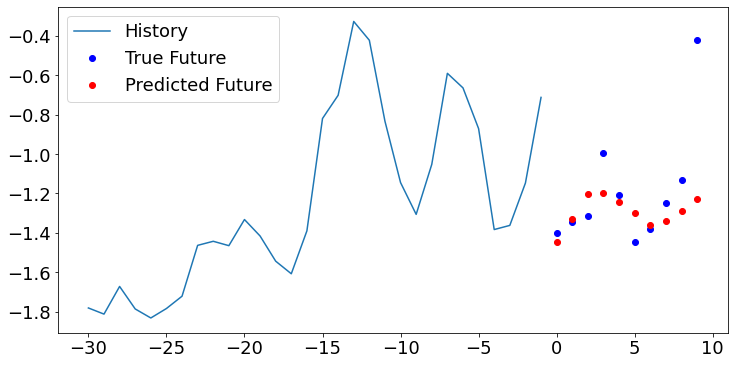

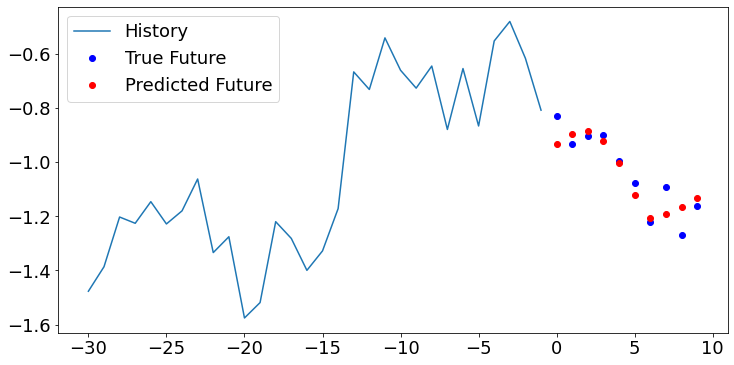

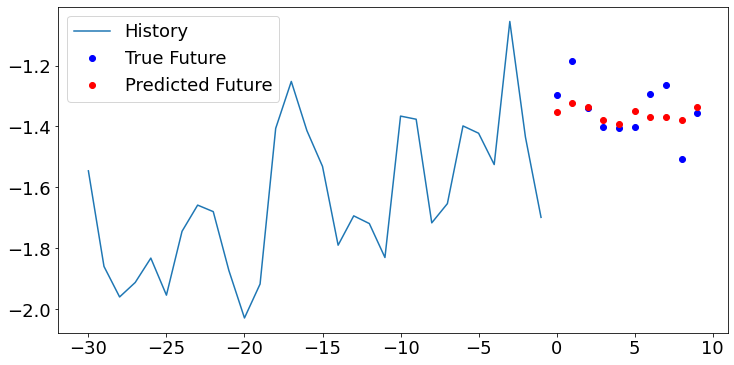

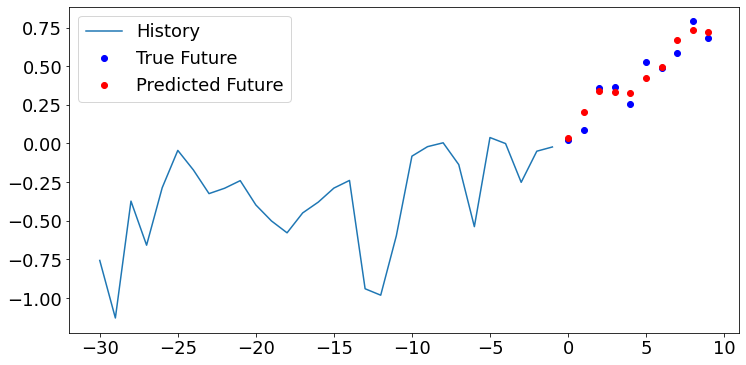

In [33]:
for x, y in val_univariate.take(5):
  multi_step_plot(x[0], y[0], bidirectional_lstm_targ10_model.predict(x)[0])

### Compare with interpolation

In [35]:
def gap_loc_and_len(sample):
    tmp = 0
    loc = []
    leng = []
    for i in range(len(sample)):
        current=sample[i]
        if not(np.isnan(current)) and tmp>0:
            leng.append(tmp)
            tmp=0
        if np.isnan(current):
            if (tmp==0) : loc.append(i)
            tmp=tmp+1
    df = pd.DataFrame({'location': loc,
                       'length': leng})
    return(df)

In [43]:
gaps = gap_loc_and_len(temp_df_15_wgaps.TEMP.values)

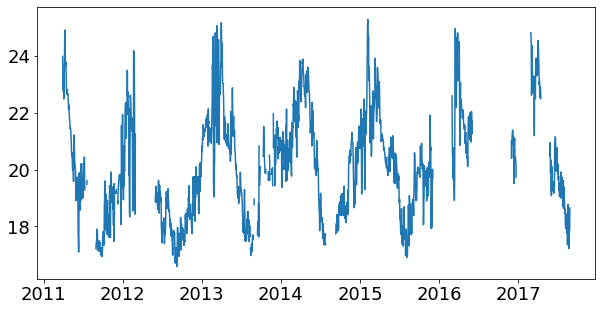

In [42]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_wgaps.index, temp_df_15_wgaps.TEMP)

In [121]:
def gapfill(samp, lstm_model, train_mean, train_std):
    gaps = gap_loc_and_len(samp.TEMP)
    for i in range(len(gaps)):
        gap_start = gaps.location[i]
        gap_length = gaps.length[i]
        hist_end = gap_start
        if gap_start < 30:
            hist_start = 0
        else:
            hist_start = gap_start - 30
        if ((gap_start >= 30) and (not np.any(np.isnan(samp.TEMP[hist_start: hist_end]))) and (gap_length <= 10)):
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(samp.TEMP.values[:gap_start][-30:], (1,30,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = bidirectional_lstm_targ10_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            samp.TEMP[gap_start : (gap_start + gap_length)] = out
    return samp

In [122]:
temp_df_15_filled = gapfill(temp_df_15_wgaps, bidirectional_lstm_targ10_model, train_mean, train_std)

In [123]:
gaps

,location,length
0,104,1
1,106,1
2,108,4
3,114,40
4,230,1
5,235,1
6,241,5
7,249,1
8,251,1
9,253,1


In [124]:
gap_loc_and_len(temp_df_15_filled.TEMP)

,location,length
0,114,40
1,337,91
2,1216,45
3,1710,88
4,1891,181
5,2095,67
6,2209,40


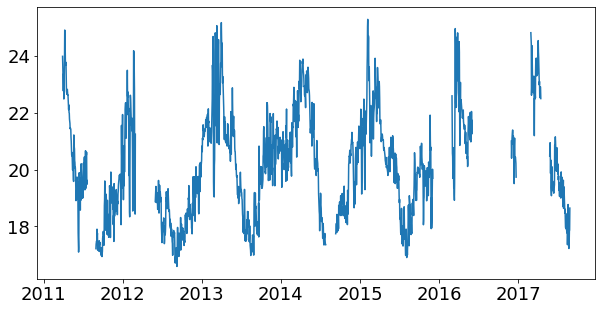

In [125]:
plt.figure(figsize=(10,5))
plt.plot(temp_df_15_filled.index, temp_df_15_wgaps.TEMP)

In [96]:
temp_df_15_filled

,TEMP
TIME,
2011-03-30,23.995378
2011-03-31,23.710236
2011-04-01,23.333200
2011-04-02,22.781210
2011-04-03,22.811733
...,...
2017-08-23,17.224247
2017-08-24,17.473562
2017-08-25,17.870966


## Three month prediction model

#### Bidirectional tri-layer LSTM model with 35 target time-steps

In [126]:
temp_df_15_filled.dropna(inplace=True)

In [127]:
# !!Important!! Run this code
Time_diff = temp_df_15_filled.index.to_series().diff()

In [160]:
hist_len = 182
targ_len = 91

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1
break_index = np.append(break_index, len(temp_df_15_filled))
window_len = hist_len + targ_len

In [161]:
data = []
labels = []

break_index = np.where(Time_diff > pd.Timedelta(days=1))[0] - 1 
window_len = hist_len + targ_len
for w in range(len(break_index)):
    run_start = hist_len if w == 0 else break_index[w-1] + 1 + hist_len
    run_end = break_index[w] - targ_len   
    for i in range(run_start, run_end):
        indices = range(i-hist_len, i)
        data.append(np.reshape(temp_df_15.values[indices], (hist_len,1)))
        labels.append(temp_df_15.values[i:i+targ_len])
        
data = np.array(data)
labels = np.array(labels)

In [162]:
data.shape, labels.shape

((689, 182, 1), (689, 91, 1))

In [163]:
# Split into training and test datasets
trainidx = np.random.choice(len(data), int(np.round(0.9*len(data))), replace=False)
train_data = data[trainidx]
train_labels = labels[trainidx]
train_labels = train_labels.reshape((len(train_labels),targ_len))
val_data = np.delete(data, obj=trainidx, axis=0)
val_labels = np.delete(labels, trainidx, axis=0)
val_labels = val_labels.reshape((len(val_labels), targ_len))

In [164]:
# Normalisation
train_mean = train_data.mean()
train_std = train_data.std()

In [165]:
train_data = (train_data-train_mean)/train_std
train_labels = (train_labels-train_mean)/train_std
val_data = (val_data-train_mean)/train_std
val_labels = (val_labels-train_mean)/train_std

In [166]:
import pickle

In [167]:
pickle_out = open("../data/train_mean-std_train-val_data-labels_hist182_targ91.pickle", "wb")
pickle.dump([train_mean, train_std, train_data, train_labels, val_data, val_labels], pickle_out)
pickle_out.close()

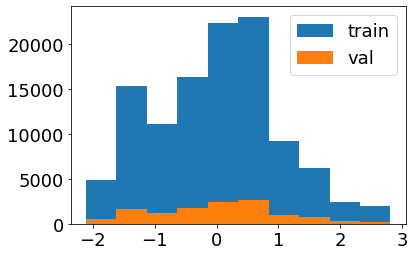

In [168]:
plt.hist(train_data.flatten(), label='train'),plt.hist(val_data.flatten(), label='val')
plt.legend()

In [169]:
BATCH_SIZE = 8
BUFFER_SIZE = data.shape[0]

train_univariate = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [170]:
bidirectional_lstm_targ91_model = tf.keras.models.Sequential([
    layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=train_data.shape[-2:])),
    layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True,)),
    layers.Bidirectional(tf.keras.layers.LSTM(8, activation='relu')),
    tf.keras.layers.Dense(91)
])

bidirectional_lstm_targ91_model.compile(optimizer='adam', loss=descaled_mape(mu=train_mean, sd=train_std), metrics=[descaled_mape(mu=train_mean, sd=train_std), 'mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])


In [171]:
# check output shape of model
bidirectional_lstm_targ91_model.predict(val_univariate.take(1)).shape

(8, 91)

In [172]:
checkpoint_path = "../data/bidirectional_lstm_daily_hist182_targ91_loss-descaledmape/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
    
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [ ]:
STEPS = int(train_data.shape[0]/BATCH_SIZE)
VAL_STEPS = int(val_data.shape[0]/BATCH_SIZE)
EPOCHS = 500

history = bidirectional_lstm_targ91_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS,
                      validation_data=val_univariate, validation_steps=VAL_STEPS, verbose=0,
                 callbacks=[cp_callback, PrintDot()])

loss:  0.0704, val_loss:  0.0640
......

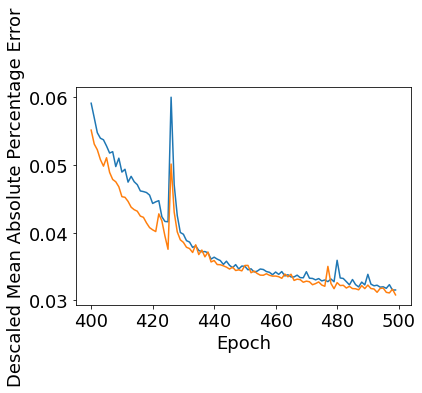

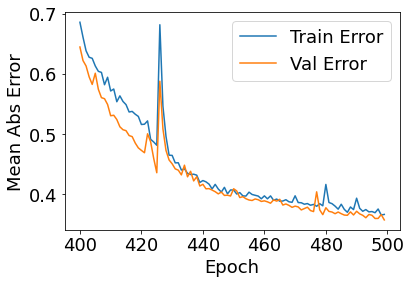

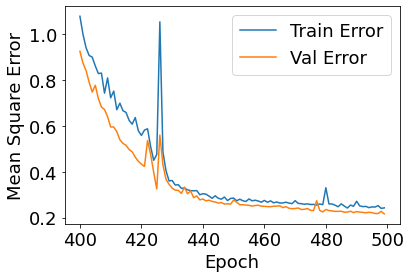

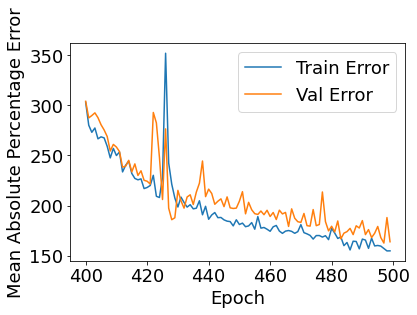

In [194]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist = hist.loc[400:]
  hist['epoch'] = history.epoch[400:]

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Descaled Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['descaled_mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_descaled_mape'],
           label = 'Val Error')
#   plt.ylim([0.9,
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [178]:
history_df = pd.DataFrame(history.history)

In [195]:
history_df

,loss,descaled_mape,mae,mse,mean_absolute_percentage_error,val_loss,val_descaled_mape,val_mae,val_mse,val_mean_absolute_percentage_error
0,0.070353,0.070353,0.803220,0.990456,122.822723,0.064005,0.064005,0.730314,0.832586,162.544418
1,0.055904,0.055965,0.643392,0.671442,196.682846,0.044004,0.044004,0.514031,0.437443,245.921021
2,0.041187,0.041241,0.479311,0.394542,199.728088,0.036578,0.036578,0.423521,0.297084,224.621750
3,0.045770,0.045649,0.520390,6.814305,191.117020,0.040998,0.040998,0.474723,0.358387,192.466995
4,0.037831,0.037847,0.439691,0.333225,203.724182,0.034483,0.034483,0.401237,0.266580,197.114838
...,...,...,...,...,...,...,...,...,...,...
495,0.032036,0.032018,0.371461,0.246492,160.096481,0.031835,0.031835,0.365284,0.221461,179.074738
496,0.031825,0.031796,0.369541,0.245663,159.474014,0.031204,0.031204,0.359967,0.217748,167.983276
497,0.032350,0.032338,0.375685,0.251886,157.078400,0.031116,0.031116,0.360060,0.217446,162.519531
498,0.031514,0.031541,0.365719,0.239845,154.658585,0.031672,0.031672,0.366422,0.227006,187.956024


In [196]:
## Save model
bidirectional_lstm_targ91_model.save('../data/saved_models/temp_gapfilling_daily_bidirectional_lstm_model_hist182_targ91_loss-descaledmape_500epochs.h5')

In [198]:
## Save History
import pickle
pickle_out = open("../data/temp_gapfilling_daily_bidirectional_lstm_model_hist182_targ91_loss-descaledmape_500epochs_history.pickle", "wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

## Recursive gap-filling and filled gap visualisation

In [39]:
def recursive_gapfill(sample, lstm_model, train_mean, train_std):
    """
    Function to fill gaps in a timeseries with a LSTM RNN model
    Args:
        sample: A numpy array of timeseries with gaps represented by NaNs
        lstm_model: A model trained on the entire sample dataset for gap-filling
        train_mean: the mean value to de(re)scale model output with
        train_std: sd to de(re)scale model output with
    """
    
    while np.any(np.isnan(sample)):
        # find the first NaN
        gap_start = np.min(np.argwhere(np.isnan(sample))) 
        if gap_start < 30:
            print('Error: There must be atleast 30 non nan values before the first gap for the prediction to work.')
            break
        else:
            # find gap length
            gap_length = np.min(np.argwhere(~np.isnan(sample[gap_start:])))
            if gap_length > 10:
                gap_length = 10
            # create history array of shape (1, 30, 1) ending at gap_start
            history = np.reshape(sample[:gap_start][-30:], (1,30,1))
            # scale history
            history = (history - train_mean)/train_std
            # use model to predict based on history and fill in sample gap
            # descale model output
            out = bidirectional_lstm_targ10_model.predict(history)[0,:gap_length]
            out = out * train_std + train_mean
            sample[gap_start : (gap_start + gap_length)] = out
        
    return sample

In [214]:
# remove predictions where there are no nans
temp_df_15.InterpTime.iloc[np.where(~np.isnan(temp_df_15.TEMP))] = np.nan
temp_df_15.LSTM_prediction.iloc[np.where(~np.isnan(temp_df_15.TEMP))] = np.nan

In [215]:
def gapfilling_comp_plot(plot_df):
  plt.figure(figsize=(12, 6))

  plt.plot(plot_df.index, plot_df.TEMP, label='Gappy timeseries')
  plt.plot(plot_df.index, plot_df.InterpTime,
           label='Interpolated')
  plt.plot(plot_df.index, plot_df.LSTM_prediction,
            label='LSTM predicted')
  plt.legend(loc='upper left')
  plt.ylabel("Temperature (degree celsius)")
  plt.xlabel("Time (years)")
  plt.show()

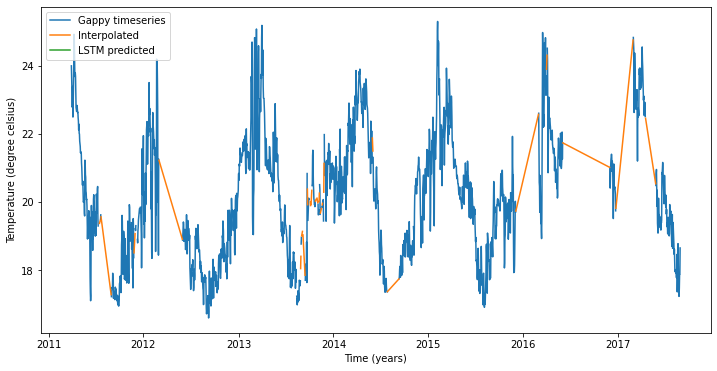

In [216]:
gapfilling_comp_plot(temp_df_15)

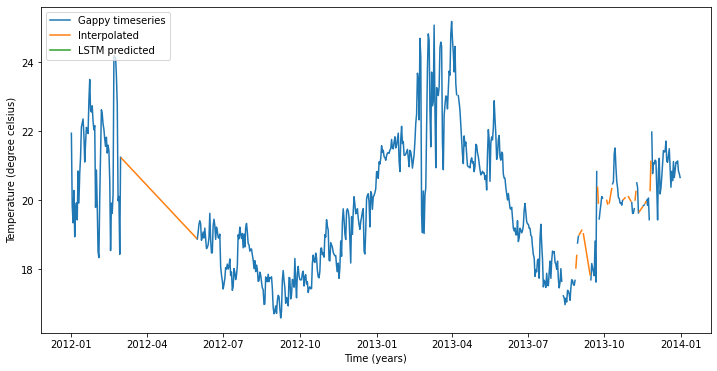

In [217]:
gapfilling_comp_plot(temp_df_15[(temp_df_15.index.year >= 2012) & (temp_df_15.index.year <= 2013)])